# User based collaborative filtering

In [107]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [47]:
## Importing data
reviews = pd.read_csv('IL_review.csv', usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business = pd.read_csv('business.csv', usecols= ['business_id', 'name'])
users = pd.read_csv('IL_users.csv', usecols= ['user_id', 'name'])

## Since users and business dataframe both have the same column names we will update them accordingly
users = users.rename(columns = { 'name': 'Username' })
business = business.rename(columns = { 'name': 'Restaurant name' })

In [48]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars'], dtype='object')

In [49]:
business.head()

,business_id,Restaurant name
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House
1,-LfTBo0oa_uD454ScEW2XA,Merry Ann's Diner
2,R32Yh0XxxanldkIp11fuRg,BoBo's BBQ
3,uJIIgBmcIn-Ye-anrqK0DQ,Dunkin'
4,4Vig7oCo9P-j2OnPUfaXCA,Papa John's Pizza


In [50]:
users.columns

Index(['user_id', 'Username'], dtype='object')

In [51]:
reviews.head()

,review_id,user_id,business_id,stars
0,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0
1,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0
2,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0
3,YIMS3PGxfWN5iFIIcYJHEg,m7rosN4Yh__tXkWP0_myqw,9MnbQg7kfb_WgxoV0hXKSQ,5.0
4,CWjzk0w-OZwzOmCut-6bvQ,iYwDTxhYStsIDHB514ltjA,t_yiQnxUDdPPCN2z4QyezA,5.0


### Since this is a userbased collaborative filtering, we will use stars given by user to make recommendations

In [53]:
# Combine the columns from the given dataframe to consist only of required columns for model
ratings_data = reviews.join(business.set_index('business_id'), on='business_id')
ratings_data = ratings_data.join(users.set_index('user_id'), on = 'user_id')
ratings_data.head()

,review_id,user_id,business_id,stars,Restaurant name,Username
0,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0,Orange & Brew,Helen
1,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0,Dublin O'Neil's,Angela
2,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0,The Bread Company,Charlie
3,YIMS3PGxfWN5iFIIcYJHEg,m7rosN4Yh__tXkWP0_myqw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,Black Dog Smoke & Ale House,Seth
4,CWjzk0w-OZwzOmCut-6bvQ,iYwDTxhYStsIDHB514ltjA,t_yiQnxUDdPPCN2z4QyezA,5.0,Golden Harbor Authentic Chinese Cuisine,Elizabeth


In [63]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(ratings_data[['user_id', 'business_id', 'stars']], reader)

# An antiset is a set of those user and item pairs for which a rating doesn't exist in original dataset
# We will use this data for testing
anti_set = data.build_full_trainset().build_anti_testset()

In [65]:
business = business.drop_duplicates(['business_id' , 'Restaurant name'])
users = users.drop_duplicates(['user_id' , 'Username'])

In [66]:
## Fit the model with 3 splits

kf = KFold(n_splits=3)
algo = KNNBasic()
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_pred = predictions

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4101
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4140
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4119


In [70]:
# calculated best predictions
best_pred[:10]

[Prediction(uid='4WcxA3F_OqVEa_Gbad16gQ', iid='9MnbQg7kfb_WgxoV0hXKSQ', r_ui=5.0, est=3.596320942652482, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='Yr91xQ_dHkYU48aLtVztzg', iid='Z2W3K8x9cRGXvlGWerZH-w', r_ui=3.0, est=3.596320942652482, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='OFoQXgVYA4UhG6SvxYxR4Q', iid='LyGab6ITDEMDI5E0YcC0Ng', r_ui=4.0, est=3.9201680672268897, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='_fEVyw4jp7YjWdOSt12hPQ', iid='PyUzLJdol6u2sSxEmJK5Cg', r_ui=4.0, est=3.596320942652482, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='VxdBd4XPX8Y45PM9IlqIrg', iid='-fiUXzkxRfbHY9TKWwuptw', r_ui=4.0, est=3.99833251282377, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='VzyVwbMC15tEbsGD4eiUkQ', iid='lrrUyxzlvqp-niBEj6_6dg', r_ui=5.0, est=3.3630769230769224, details={'actual_k': 13, 'was_impossible': False}),
 Pre

In [71]:
# Fitting with splits 5
kf = KFold(n_splits=5)
sim_options = {'name':'cosine'}
algo = KNNWithMeans(sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_rmse= rmse
        best_pred = predictions
print(best_rmse)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4127
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4281
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4212
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4151
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4303
1.4127130998854653


In [72]:
best_pred[:10]

[Prediction(uid='WJdXYIM5cphh_28C5Bhnfw', iid='sjpsGKPABZDnABCv3wYtUQ', r_ui=1.0, est=3.3917235776314043, details={'actual_k': 25, 'was_impossible': False}),
 Prediction(uid='Z5R5UP2MkcJbCcphQW8gng', iid='sjpsGKPABZDnABCv3wYtUQ', r_ui=5.0, est=4.545583655274023, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='UxsPF9Zmi95x9fausVyxcw', iid='kj44upIDaMIPlYvsuweP4g', r_ui=4.0, est=4.67025861486602, details={'actual_k': 34, 'was_impossible': False}),
 Prediction(uid='e2g9Y0n4qgR4r8YgIF6ghg', iid='LvPbZ_5odnjE_oj5BNHivQ', r_ui=1.0, est=3.5958108155840485, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='r9DthGcr9v7OU_IoBH6QmQ', iid='e0prCZXtHGQIKeQ_wTW3uw', r_ui=4.0, est=3.366933314866844, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='zqYvKAZF74cnnxijHV5GtQ', iid='hjo4IYguwprIJ16A8lV75A', r_ui=5.0, est=3.5958108155840485, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Predicti

In [73]:
kf = KFold(n_splits=3)
algo = KNNBaseline(k=3)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse = rmse
        best_algo = algo
        best_pred = predictions

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3662
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3808
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3702


### Changing similarity option and setting the preference to user based filtering

In [101]:
sim_options = { 'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions
    

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4053
[Prediction(uid='gbFwBci1et6i5E-kdGMVRg', iid='sYf2auhosrx8trbyP9nGyw', r_ui=5.0, est=3.592137331779167, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}), Prediction(uid='guPaExaSjcXIVVBrDFK3pg', iid='9MnbQg7kfb_WgxoV0hXKSQ', r_ui=5.0, est=4.742782512478989, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='gqRxy4PEc7bz2GoSN5WZ9g', iid='UUsS7SrTQQ2AvvpslfrvFA', r_ui=4.0, est=4.349298156280084, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid='KC3iVc5G4m8P5HJD22GVwg', iid='zQNJwaWR1M1zDjLNVJiNEw', r_ui=5.0, est=3.5400896262620773, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='c6JwWKzUTLTjZZDHQpBzlQ', iid='9MnbQg7kfb_WgxoV0hXKSQ', r_ui=5.0, est=4.044483445630416, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='OhS5ZfSqA3Miuh2cw0W3Qg', iid='t_yiQnxUDdPPCN2z4QyezA', r_ui=5.0, est=3.590228084720939, detai

Done computing similarity matrix.
RMSE: 1.4081
[Prediction(uid='joFAJDSxQpFd_uBbUi-grA', iid='5_cn7M-9swHrFbnqZtYGBQ', r_ui=4.0, est=4.543591897212559, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='bO0EGviJJtza7CpD3z0gxg', iid='Igr5Id1TWyM3JLsY_td9_w', r_ui=4.0, est=4.306463651291238, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid='01wsBmFLD_BLELpEdGCiwg', iid='o80p16nM5CWbl22JP1nB-w', r_ui=5.0, est=4.213247863247863, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='NVYsLQLS6nQVHui82zb4uQ', iid='k441Clzdv9Ia4QZanEne3g', r_ui=5.0, est=3.46405382650513, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='StYuEMDMWO1IOdMz5zgE8Q', iid='boIILzBqhjWhq4G0BsB5_A', r_ui=4.0, est=2.983866375836575, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid='wklmU8CM7czQQBuhOC4k9A', iid='PGUuVJEzM0H-ZMB6m1D6Ig', r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid='cny_pAae3eh006GNhrD-sQ'

Done computing similarity matrix.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done computing similarity matrix.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Analyzing the predictions

In [75]:
pred_df = pd.DataFrame(best_pred).merge(ratings_data , left_on = ['uid', 'iid'], right_on = ['user_id', 'business_id'])
pred_df[['uid', 'iid',  'Username', 'user_id', 'Restaurant name', 'business_id', 'est','stars']]

,uid,iid,Username,user_id,Restaurant name,business_id,est,stars
0,5AQK8j6FFGFEufTRTDWVSA,9MnbQg7kfb_WgxoV0hXKSQ,Kat,5AQK8j6FFGFEufTRTDWVSA,Black Dog Smoke & Ale House,9MnbQg7kfb_WgxoV0hXKSQ,3.280757,3.0
1,oleCRhqtIa3XNpiVKobeJQ,aGrdbIsBr28EegRnk8fRcw,Tamara,oleCRhqtIa3XNpiVKobeJQ,Walmart Supercenter,aGrdbIsBr28EegRnk8fRcw,1.928387,1.0
2,oleCRhqtIa3XNpiVKobeJQ,aGrdbIsBr28EegRnk8fRcw,Tamara,oleCRhqtIa3XNpiVKobeJQ,Walmart Supercenter,aGrdbIsBr28EegRnk8fRcw,1.928387,1.0
3,CodKzXlUZwyKhQnnm8TspQ,VIJ2KiDKhUVhhpNylEIfog,Frankie,CodKzXlUZwyKhQnnm8TspQ,Maize Mexican Grill,VIJ2KiDKhUVhhpNylEIfog,5.000000,4.0
4,W50U-g7SA2iC_KlfFNBC2A,PyUzLJdol6u2sSxEmJK5Cg,Elly,W50U-g7SA2iC_KlfFNBC2A,Neil St Blues,PyUzLJdol6u2sSxEmJK5Cg,3.595987,5.0
...,...,...,...,...,...,...,...,...
7594,HOhhqA66XDy2oM2nsof48A,fl2TPNWrchkCbNEg0utjvw,Bryant,HOhhqA66XDy2oM2nsof48A,Steak ’n Shake,fl2TPNWrchkCbNEg0utjvw,1.583333,5.0
7595,v-T3dKShaiqmeJY1Ny50AA,BLtzUCwmGOSVgPJ78N3ORA,William,v-T3dKShaiqmeJY1Ny50AA,Tang Dynasty,BLtzUCwmGOSVgPJ78N3ORA,2.833333,1.0
7596,6cA1NZddDR-OnxAv8tVKog,E6QAh8UPRo6Tlg6hkcWCHw,Angie,6cA1NZddDR-OnxAv8tVKog,Bombay Indian Grill,E6QAh8UPRo6Tlg6hkcWCHw,3.595987,5.0
7597,d0cdw9tkSB5VQwkAqLVHdA,HAgPykErkXpPJlwOHbY01Q,Jonathan,d0cdw9tkSB5VQwkAqLVHdA,J Gumbo's,HAgPykErkXpPJlwOHbY01Q,3.869050,5.0


In [78]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(business , left_on = ['iid'], right_on = ['business_id'])
pred_df = pd.DataFrame(pred_df).merge(users , left_on = ['uid'], right_on = ['user_id'])

In [79]:
pred_df

,uid,iid,r_ui,est,details,business_id,Restaurant name,user_id,Username
0,6X0i-oGUbh5DZdTHzFuKfg,VHsNB3pdGVcRgs6C3jt6Zg,3.599084,3.544572,"{'actual_k': 3, 'was_impossible': False}",VHsNB3pdGVcRgs6C3jt6Zg,Dublin O'Neil's,6X0i-oGUbh5DZdTHzFuKfg,Helen
1,6X0i-oGUbh5DZdTHzFuKfg,Ah4i15g8Ow_zphzcpulTxQ,3.599084,3.908560,"{'actual_k': 3, 'was_impossible': False}",Ah4i15g8Ow_zphzcpulTxQ,The Bread Company,6X0i-oGUbh5DZdTHzFuKfg,Helen
2,6X0i-oGUbh5DZdTHzFuKfg,9MnbQg7kfb_WgxoV0hXKSQ,3.599084,3.350904,"{'actual_k': 3, 'was_impossible': False}",9MnbQg7kfb_WgxoV0hXKSQ,Black Dog Smoke & Ale House,6X0i-oGUbh5DZdTHzFuKfg,Helen
3,6X0i-oGUbh5DZdTHzFuKfg,t_yiQnxUDdPPCN2z4QyezA,3.599084,3.271115,"{'actual_k': 3, 'was_impossible': False}",t_yiQnxUDdPPCN2z4QyezA,Golden Harbor Authentic Chinese Cuisine,6X0i-oGUbh5DZdTHzFuKfg,Helen
4,6X0i-oGUbh5DZdTHzFuKfg,-fiUXzkxRfbHY9TKWwuptw,3.599084,4.169767,"{'actual_k': 3, 'was_impossible': False}",-fiUXzkxRfbHY9TKWwuptw,DESTIHL Restaurant & Brew Works,6X0i-oGUbh5DZdTHzFuKfg,Helen
...,...,...,...,...,...,...,...,...,...
10831627,fnNSkK1yp5_Th48_gDkj_g,-5NXoZeGBdx3Bdk70tuyCw,3.599084,2.589545,"{'actual_k': 3, 'was_impossible': False}",-5NXoZeGBdx3Bdk70tuyCw,Po' Boys Restaurant,fnNSkK1yp5_Th48_gDkj_g,Lorelei
10831628,fnNSkK1yp5_Th48_gDkj_g,0ptR21GHRuQ1MFtxGNcxzw,3.599084,2.558369,"{'actual_k': 3, 'was_impossible': False}",0ptR21GHRuQ1MFtxGNcxzw,Milo's Restaurant,fnNSkK1yp5_Th48_gDkj_g,Lorelei
10831629,fnNSkK1yp5_Th48_gDkj_g,O3zVw-VAcJi8ta4B6v5iAA,3.599084,3.790985,"{'actual_k': 3, 'was_impossible': False}",O3zVw-VAcJi8ta4B6v5iAA,Sun Singer Wine and Spirits,fnNSkK1yp5_Th48_gDkj_g,Lorelei
10831630,fnNSkK1yp5_Th48_gDkj_g,dHkbBWmXXjaO_-9BgQyEPg,3.599084,3.065451,"{'actual_k': 3, 'was_impossible': False}",dHkbBWmXXjaO_-9BgQyEPg,Moki Sushi,fnNSkK1yp5_Th48_gDkj_g,Lorelei


In [87]:
## Recommend a restaurant to the user if the estimated rating is equal to 5

pred_df[(pred_df['est'] == 5)&(pred_df['user_id']=='6X0i-oGUbh5DZdTHzFuKfg')]

,uid,iid,r_ui,est,details,business_id,Restaurant name,user_id,Username
24,6X0i-oGUbh5DZdTHzFuKfg,RO8_riptsSLrFRNs08vObA,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",RO8_riptsSLrFRNs08vObA,Rich's Family Restaurant,6X0i-oGUbh5DZdTHzFuKfg,Helen
36,6X0i-oGUbh5DZdTHzFuKfg,WAAYgXdq-1zdo5Je-pq3kg,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",WAAYgXdq-1zdo5Je-pq3kg,Columbia Street Roastery By Herriott's,6X0i-oGUbh5DZdTHzFuKfg,Helen
55,6X0i-oGUbh5DZdTHzFuKfg,odFzgrbzkCuWLTPWbYHdkw,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",odFzgrbzkCuWLTPWbYHdkw,English Hedgerow,6X0i-oGUbh5DZdTHzFuKfg,Helen
58,6X0i-oGUbh5DZdTHzFuKfg,BQMVcJQV70gUQjwi7-MrSg,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",BQMVcJQV70gUQjwi7-MrSg,Gustoso Authentic Italian Pasta and Pizza,6X0i-oGUbh5DZdTHzFuKfg,Helen
61,6X0i-oGUbh5DZdTHzFuKfg,y-xy2Bp2k7CoIYUKFjKUFg,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",y-xy2Bp2k7CoIYUKFjKUFg,Sugar By Sarah,6X0i-oGUbh5DZdTHzFuKfg,Helen
...,...,...,...,...,...,...,...,...,...
800,6X0i-oGUbh5DZdTHzFuKfg,68HNLNwMfXu1NuL_2E4N7A,3.599084,5.0,"{'actual_k': 2, 'was_impossible': False}",68HNLNwMfXu1NuL_2E4N7A,Doodles,6X0i-oGUbh5DZdTHzFuKfg,Helen
801,6X0i-oGUbh5DZdTHzFuKfg,8YWZdOcyR2iXpKjp5NpzWQ,3.599084,5.0,"{'actual_k': 0, 'was_impossible': False}",8YWZdOcyR2iXpKjp5NpzWQ,Smoothie King,6X0i-oGUbh5DZdTHzFuKfg,Helen
824,6X0i-oGUbh5DZdTHzFuKfg,uma0HNsysznSfPbQb2HD5g,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",uma0HNsysznSfPbQb2HD5g,Saigon Vietnamese Cuisine,6X0i-oGUbh5DZdTHzFuKfg,Helen
826,6X0i-oGUbh5DZdTHzFuKfg,RePugRsryh7skCUdEAeDfQ,3.599084,5.0,"{'actual_k': 1, 'was_impossible': False}",RePugRsryh7skCUdEAeDfQ,Breaking Taco,6X0i-oGUbh5DZdTHzFuKfg,Helen


In [93]:
## get restaurants recommendations for given user

def get_recommendations(user_id, estimated_prediction):
    df_recommended = pred_df[(pred_df['est'] >= estimated_prediction) & (pred_df['user_id'] == user_id)]
    restaurants = df_recommended['Restaurant name']
    return restaurants

In [89]:
users.head()

,user_id,Username
0,fcNU65OaCj7slBJ60VSQgw,Steven
1,4mjnkd8oJVCfBKN3i4rB-g,Tricia
2,ZdYHJ-hctaaDeH1CpP7-EA,Colleen
3,JWgti_adPZywG9SKUbnB-w,Sarah
4,PIzmdHF7p9GwXhwt3b3JxQ,Sasuke


In [96]:
## get recommendations for first five users with estimated rating greater than 5

for user in users.head(5).itertuples():
    print(user)
    recommendations = get_recommendations(user.user_id, 5)
    print('\n\nRecommendations are listed below for user ', user.Username)
    print('\n Top 10 Recommended Restaurants')
    print(recommendations[:10])

Pandas(Index=0, user_id='fcNU65OaCj7slBJ60VSQgw', Username='Steven')


Recommendations are listed below for user  Steven

 Top 10 Recommended Restaurants
7267212                 Pies by Inge
7267214       B. Lime, A Green Store
7267285                Cakes By Lori
7267363            Dom's Patio Villa
7267382                  Cafe Sababa
7267383                   Fernando’s
7267425    WackyNackies Gifts & Cafe
7267470              Buzzard's Place
7267472                      Scratch
7267509      Mansfield General Store
Name: Restaurant name, dtype: object
Pandas(Index=1, user_id='4mjnkd8oJVCfBKN3i4rB-g', Username='Tricia')


Recommendations are listed below for user  Tricia

 Top 10 Recommended Restaurants
60145       B. Lime, A Green Store
60213                Cakes By Lori
60289            Dom's Patio Villa
60295    Salt and Light Ministries
60322                   Aroma Cafe
60350    WackyNackies Gifts & Cafe
60395              Buzzard's Place
60397                      Scratch
60450

## Evaluation

### Finding Precision and Recall using a base threshold at 3.5

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [108]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [109]:
kf = KFold(n_splits=5)
algo = SVD()

prec_to_ave = []
rec_to_ave = []

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [110]:
def make_binary_tpr_fpr(predictions, threshold=3.5):
    pred_df = pd.DataFrame(predictions)
    pred_df['r_ui'].where(pred_df['r_ui']>threshold, 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<=threshold, 0, inplace=True)
    
    pred_df['est'].where(pred_df['est']>threshold, 1, inplace=True)
    pred_df['est'].where(pred_df['est']<=threshold, 0, inplace=True)

    return pred_df['r_ui'], pred_df['est'], 

true_r, est = make_binary_tpr_fpr(predictions)

In [111]:
fpr, tpr, thresholds = roc_curve(true_r, est)

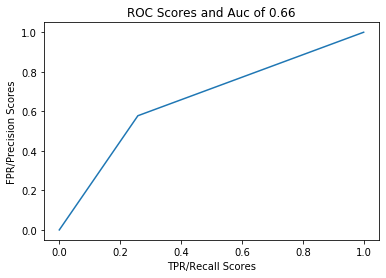

In [112]:
def graph_roc (true_r, est):
    
    fpr, tpr, thresholds = roc_curve(true_r, est)
    auc_ = auc(fpr, tpr)
    plt.plot(fpr,tpr, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(round(auc_, 2)))
    plt.show()
    
graph_roc(true_r, est)

In [113]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0} and {1}, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.9382138273434426 and 0.5685636326910913, respectively


### Precision and Recall values using User-Average Ratings as a Threshold

In [122]:
def user_ave_rating_threshold(df, n):
    ''' Function that averages a unique reviewerID's ratings if they have reviewed more than n books
        and returns a dictionary of threshold values and ids'''
    print(df)
    
    threshold_dict = defaultdict(list)
    
    # note--> to optimize only find the mean if it means the user_Rating_count
    
    user_ratings_ave= df.groupby('user_id')['stars'].mean()
    user_ratings_count = df.groupby('user_id')['stars'].count()
    
    for x in df['user_id'].unique():
        if user_ratings_count[x] > n:
            threshold_dict[x] = user_ratings_ave[x]
        else:
            threshold_dict[x] = 3.5
    
    return(threshold_dict)
            
        
threshold_diction = user_ave_rating_threshold(ratings_data, 8)

                    review_id                 user_id             business_id  \
0      m4AXzV9l14iFBd9DRdM82w  6X0i-oGUbh5DZdTHzFuKfg  9A1C1f0m4nQltQrOOTl-Kw   
1      A-yKlSLEQQcoHR5q2lCyHg  Yximlvn0cfb3yVDaLuXDxw  VHsNB3pdGVcRgs6C3jt6Zg   
2      asLnux3k2yqoVjcJcLuF0g  Cz8l7JQ2I_RhtK0BosH-7Q  Ah4i15g8Ow_zphzcpulTxQ   
3      YIMS3PGxfWN5iFIIcYJHEg  m7rosN4Yh__tXkWP0_myqw  9MnbQg7kfb_WgxoV0hXKSQ   
4      CWjzk0w-OZwzOmCut-6bvQ  iYwDTxhYStsIDHB514ltjA  t_yiQnxUDdPPCN2z4QyezA   
...                       ...                     ...                     ...   
35384  Fsn4u2RjnCS4kbO0OIqcCQ  51Dsi3GU4fcfxYYuW2JscQ  ly0oNXKOoSZyr0mzOsVJhg   
35385  ZnE93UGlk29kX0dfwMOGNw  ViqyzZgObMSOwWBoQbLjSg  PBmfdx-tC2D54FI3HtcKww   
35386  fGgMD8npNcGyx_Fr91m_Dg  Nl9ouJ9EqcNCX7gdPw9ZCw  dn9lwYUxmhs_mLKPu7L25Q   
35387  PJaQsm03aJVWH9xg03WN9g  Kb0rYUpYzjJqoM7cAWZBAQ  k0SB_IQ41iHessjK4hM2LA   
35388  flX4YICNgGSs2QriJ2CgRw  x4XrrBXlKABQCyv1AMHHrA  l4x5FFzfiCFrGN0S-uZbBQ   

       stars               

In [123]:
def precision_recall_at_k(predictions, threshold_dictionary, k=10):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        threshold = threshold_dictionary[uid]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [124]:
kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold_diction, k=5)

    # Precision and recall can then be averaged over all users
  
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [125]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0}.2f and {1}.2f, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.8786089314448724.2f and 0.6819169047614358.2f, respectively


In [126]:
def make_binary_tpr_fpr_user(predictions, threshold_diction):
    
    pred_df = pd.DataFrame(predictions)
    
    pred_df['threshold'] = pred_df['uid'].map(threshold_diction)
    pred_df['r_ui'].where(pred_df['r_ui']>=pred_df['threshold'], 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<pred_df['threshold'], 0, inplace=True)
    pred_df['est'].where(pred_df['est']>=pred_df['threshold'], 1, inplace=True)
    pred_df['est'].where(pred_df['est']<pred_df['threshold'], 0, inplace=True)
    
    return pred_df['r_ui'], pred_df['est']

true_r_ut, est_ut = make_binary_tpr_fpr_user(predictions, threshold_diction)

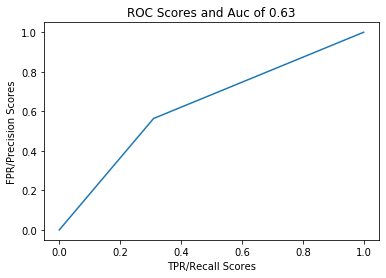

In [127]:
graph_roc(true_r_ut, est_ut)